# Analysis tools

Before we start, we create an atmospheric setup case based on the ["Getting Started"](./getting_started.ipynb) example:

First setting up the Radtrans object:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from petitRADTRANS.radtrans import Radtrans
from petitRADTRANS import physical_constants as cst

atmosphere = Radtrans(pressures = np.logspace(-6,3,100),
                      line_species = ['H2O', 
                                      'CO-NatAbund', 
                                      'CH4', 
                                      'CO2', 
                                      'Na__Burrows',
                                      'K__Burrows'],
                      rayleigh_species = ['H2', 'He'],
                      gas_continuum_contributors = ['H2-H2', 'H2-He'],
                      wavelength_boundaries = [0.3, 15])

Loading Radtrans opacities...
 Loading line opacities of species 'H2O' from file '/Users/nasedkin/testing/input_data/opacities/lines/correlated_k/H2O/1H2-16O/1H2-16O__POKAZATEL.R1000_0.3-50mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'CO-NatAbund' from file '/Users/nasedkin/testing/input_data/opacities/lines/correlated_k/CO/C-O-NatAbund/C-O-NatAbund__HITEMP.R1000_0.1-250mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'CH4' from file '/Users/nasedkin/testing/input_data/opacities/lines/correlated_k/CH4/12C-1H4/12C-1H4__YT34to10.R1000_0.3-50mu.ktable.petitRADTRANS.h5.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'CO2' from file '/Users/nasedkin/testing/input_data/opacities/lines/correlated_k/CO2/12C-16O2/12C-16O2__UCL-4000.R1000_0.3-50mu.ktable.petitRADTRANS.h5.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'Na__Burrows' from file '/Users/nasedkin/testing/input_data/opacities/lines/correlated_k

<div class="alert alert-warning">

**Units in petitRADTRANS:** all units inside *petitRADTRANS* are in cgs. However, when interfacing with the code, you are expected to provide pressures in bars (more intuitive). Pressures will be converted to cgs units within the code.
</div>

And the atmospheric parameters:

In [2]:
planet_radius = 1.*cst.r_jup_mean
reference_gravity = 10**3.5
reference_pressure = 0.01

from petitRADTRANS.physics import temperature_profile_function_guillot_global

pressures_bar = atmosphere.pressures*1e-6 # cgs to bar
kappa_IR = 0.01
gamma = 0.4
T_int = 200.
T_equ = 1500.

temperatures = temperature_profile_function_guillot_global(pressures_bar, kappa_IR, gamma, reference_gravity, T_int, T_equ)

mass_fractions = {}
mass_fractions['H2'] = 0.74 * np.ones_like(temperatures)
mass_fractions['He'] = 0.24 * np.ones_like(temperatures)
mass_fractions['H2O'] = 1e-3 * np.ones_like(temperatures)
mass_fractions['CO-NatAbund'] = 1e-2 * np.ones_like(temperatures)
mass_fractions['CO2'] = 1e-4 * np.ones_like(temperatures)
mass_fractions['CH4'] = 1e-5 * np.ones_like(temperatures)
mass_fractions['Na'] = 1e-4 * np.ones_like(temperatures)
mass_fractions['K'] = 1e-6 * np.ones_like(temperatures)

            #  2.33 is a typical value for H2-He dominated atmospheres
mean_molar_masses = 2.33 * np.ones_like(temperatures)

<div class="alert alert-warning">

**Abundances in petitRADTRANS:** abundances in pRT are in units of **mass fractions**, not number fractions (aka volume mixing ratio, VMR). One can convert between mass fractions and VMRs by using
\begin{equation}
X_i = \frac{\mu_i}{\mu}n_i,
\end{equation}
where $X_i$ is the mass fraction of species $i$, $\mu_i$ the molar mass of a molecule/atom/ion/... of species $i$, $\mu$ is the atmospheric mean molar mass, and $n_i$ is the VMR of species $i$. This is implemented in `petitRADTRANS.chemistry.utils.mass_fractions2volume_mixing_ratios()` and `petitRADTRANS.chemistry.utils.volume_mixing_ratios2mass_fractions()`.

</div>

## Transmission contribution functions

We calculate the transmission spectrum in the usual way, this time setting the ``return_contribution = True`` keyword argument, however. This will additionally measure the contribution of the different layers, by calculating as many transmission spectra as there are layers, iteratively turning off the opacity in one layer only. The difference to the nominal transmission spectrum then measures the influence of the respective layers. Note that calculating the contribution function will increase the computation time considerably. The formal definition of the contribution function is [(Mollière et al. 2019)](https://ui.adsabs.harvard.edu/abs/2019A%26A...627A..67M/abstract):

\begin{equation}
C_{\rm tr}^{i} = \frac{R_{\rm nom}^2-R^2(\kappa_i=0)}{\sum_{j=1}^{N_{\rm L}}\left[R_{\rm nom}^2-R^2(\kappa_j=0)\right]},
\end{equation}

where $R_{\rm nom}$ is the nominal transmission radius of the planet and $R(\kappa_i=0)$ is the transmission radius obtained from setting the opacity in the $i$th layer to zero. $N_{\rm L}$ is the number of atmospheric layers.

Now, to the contribution function calculation:

In [3]:
wavelengths, transit_radii, additional_outputs = atmosphere.calculate_transit_radii(temperatures=temperatures, 
                                                                   mass_fractions=mass_fractions, 
                                                                   mean_molar_masses=mean_molar_masses, 
                                                                   reference_gravity=reference_gravity, 
                                                                   planet_radius=planet_radius, 
                                                                   reference_pressure=reference_pressure,
                                                                   return_contribution=True)

The transmission contribution function is plotted below, one can see that pressures above ~1 bar (so altitudes below 1 bar) cannot be probed in the wavelength range studied here.

Text(0.5, 1.0, 'Transmission contribution function')

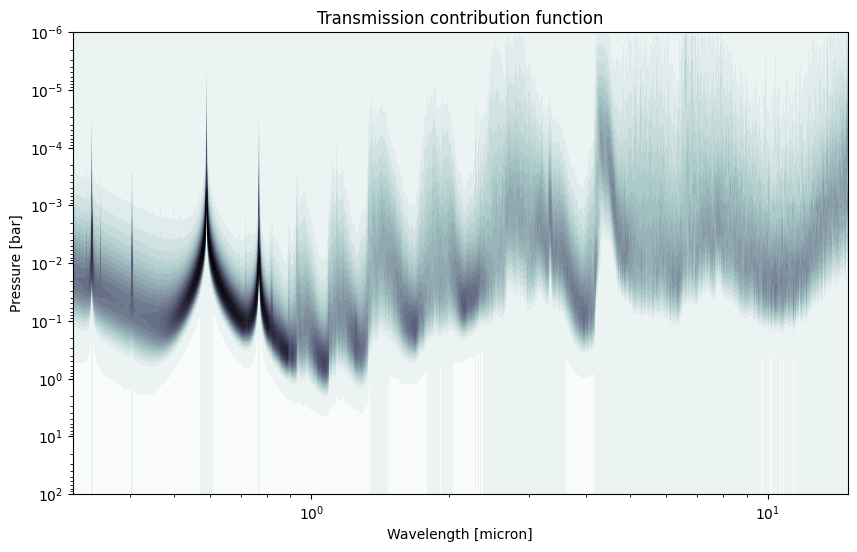

In [4]:
wlen_mu = wavelengths/1e-4
X, Y = np.meshgrid(wlen_mu, pressures_bar)

fig,ax = plt.subplots(figsize=(10,6))
ax.contourf(X,Y,additional_outputs['transmission_contribution'],30,cmap=plt.cm.bone_r)

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim([1e2,1e-6])
ax.set_xlim([np.min(wlen_mu),np.max(wlen_mu)])

ax.set_xlabel('Wavelength [micron]')
ax.set_ylabel('Pressure [bar]')
ax.set_title('Transmission contribution function')


## Emission contribution functions

Now we show the same for the emission contribution functions, which are defined in the usual way, that is, measuring the fraction of flux a layer contributes to the total flux, at a given wavelength (see, e.g., [Mollière et al. 2019](https://ui.adsabs.harvard.edu/abs/2019A%26A...627A..67M/abstract)). The computational time is comparable to a normal emission spectrum. To see the difference between the non-scattering (calculated here) and scattering emission contribution functions (calculated below), we will decrease the alkali opacities.

In [5]:
mass_fractions['Na'] = 1e-5 * np.ones_like(temperatures)
mass_fractions['K'] = 1e-7 * np.ones_like(temperatures)

wavelengths, flux, additional_outputs = atmosphere.calculate_flux(temperatures=temperatures,
                          mass_fractions=mass_fractions, 
                          mean_molar_masses=mean_molar_masses, 
                          reference_gravity=reference_gravity,
                          return_contribution=True)

The emission contribution function is plotted below, one can see that at the bluest wavelengths, pressures that pressures up to ~100 bar can not be probed.

Text(0.5, 1.0, 'Emission contribution function')

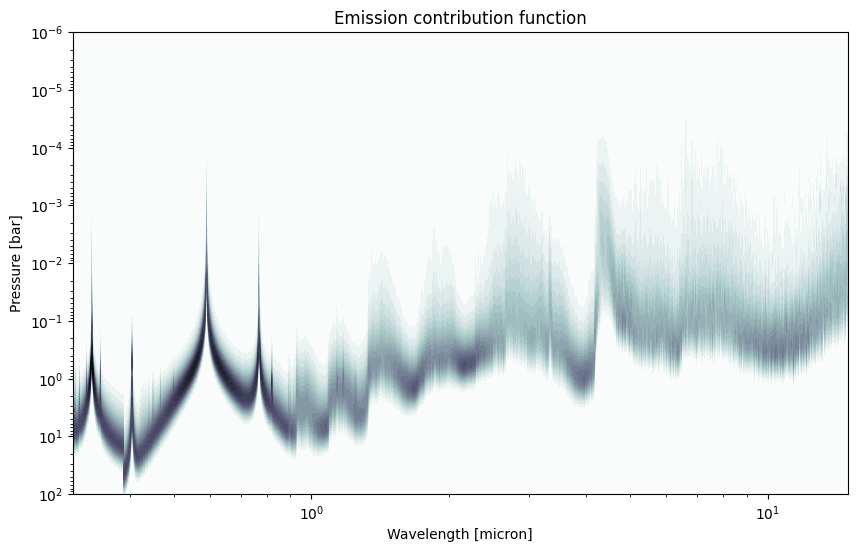

In [6]:
fig,ax = plt.subplots(figsize=(10,6))
ax.contourf(X,Y,additional_outputs['emission_contribution'],30,cmap=plt.cm.bone_r)

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim([1e2,1e-6])
ax.set_xlim([np.min(wlen_mu),np.max(wlen_mu)])

ax.set_xlabel('Wavelength [micron]')
ax.set_ylabel('Pressure [bar]')
ax.set_title('Emission contribution function')

One also sees that scattering is not included in the pRT emission spectrum here, as blueward of the strong alkali lines in the optical, quite large pressures can be probed. Conversely, in the transmission contribution plot above, the Rayleigh scattering is clearly visible. Hence, we will turn on scattering in the calculation below to show its impact on the spectra.

<div class="alert alert-warning">

**Scattering and petitRADTRANS:** remember that scattering is included for emission spectra in petitRADTRANS only if requested specifically when generating the Radtrans object, as it increases the runtime (see ["Scattering for Emission Spectra"](./scattering_for_emission_spectra.ipynb) for an example how to do this).
</div>

First we reload the pRT object with scattering turned on:

In [7]:
atmosphere_scat = Radtrans(pressures = np.logspace(-6,3,100),
                           line_species = ['H2O', 
                                           'CO-NatAbund', 
                                           'CH4', 
                                           'CO2', 
                                           'Na__Burrows',
                                           'K__Burrows'],
                           rayleigh_species = ['H2', 'He'],
                           gas_continuum_contributors = ['H2-H2', 'H2-He'],
                           wavelength_boundaries = [0.3, 15],
                           scattering_in_emission = True)

Loading Radtrans opacities...
 Loading line opacities of species 'H2O' from file '/Users/nasedkin/testing/input_data/opacities/lines/correlated_k/H2O/1H2-16O/1H2-16O__POKAZATEL.R1000_0.3-50mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'CO-NatAbund' from file '/Users/nasedkin/testing/input_data/opacities/lines/correlated_k/CO/C-O-NatAbund/C-O-NatAbund__HITEMP.R1000_0.1-250mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'CH4' from file '/Users/nasedkin/testing/input_data/opacities/lines/correlated_k/CH4/12C-1H4/12C-1H4__YT34to10.R1000_0.3-50mu.ktable.petitRADTRANS.h5.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'CO2' from file '/Users/nasedkin/testing/input_data/opacities/lines/correlated_k/CO2/12C-16O2/12C-16O2__UCL-4000.R1000_0.3-50mu.ktable.petitRADTRANS.h5.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'Na__Burrows' from file '/Users/nasedkin/testing/input_data/opacities/lines/correlated_k

Now we recalculate and plot the emission contribution function:

Text(0.5, 1.0, 'Emission contribution function')

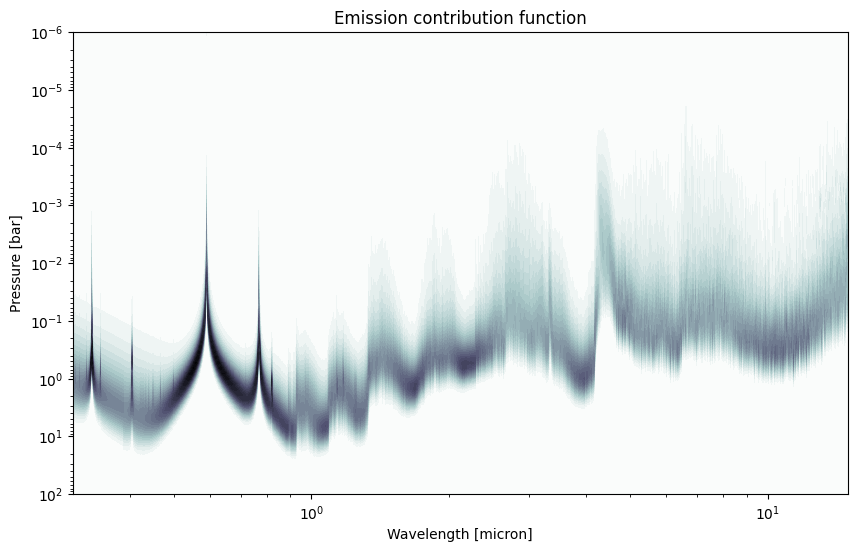

In [8]:
wavelengths, flux, additional_outputs = atmosphere_scat.calculate_flux(temperatures=temperatures,
                          mass_fractions=mass_fractions, 
                          mean_molar_masses=mean_molar_masses, 
                          reference_gravity=reference_gravity,
                          return_contribution=True)

fig,ax = plt.subplots(figsize=(10,6))
ax.contourf(X,Y,additional_outputs['emission_contribution'],30,cmap=plt.cm.bone_r)

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim([1e2,1e-6])
ax.set_xlim([np.min(wlen_mu),np.max(wlen_mu)])

ax.set_xlabel('Wavelength [micron]')
ax.set_ylabel('Pressure [bar]')
ax.set_title('Emission contribution function')

As can be seen, the Rayleigh scattering contribution to the emitted flux leaving the atmosphere is clearly visible now, with maximum probed pressures being in the range of 10, rather than 100 bar.

## Plotting opacities

pRT can also be used to plot opacities. For this we can use the `plot_radtrans_opacities()` method, which we import here:

In [9]:
from petitRADTRANS.plotlib import plot_radtrans_opacities

Next we plot the line opacities of the Radtrans object called `atmosphere` created above. This will assume (equal) abundances of 1 for the different species. Chemical equilibrium abundances are also possible, see below. Here we plot all line species of the Radtrans object, but also a subset of them is possible. Just give a list, for example `['H2O', 'CO-NatAbund']`, instead of `atmosphere.line_species`, to the function. If you initialized your Radtrans object with `line_opacity_mode='lbl'` it will plot the high resolution opacities. For the default `line_opacity_mode='c-k'` it will plot the frequency-averaged opacities within the correlated-k frequency bins, like defined here for frequency bin $i$:
$$
\hat{\kappa}_i = \frac{1}{\Delta \nu_i} \int_{\nu_i - \Delta \nu_i/2}^{\nu_i + \Delta \nu_i / 2} \kappa(\nu)d\nu = \int_0^1 \kappa_i(g)dg
$$

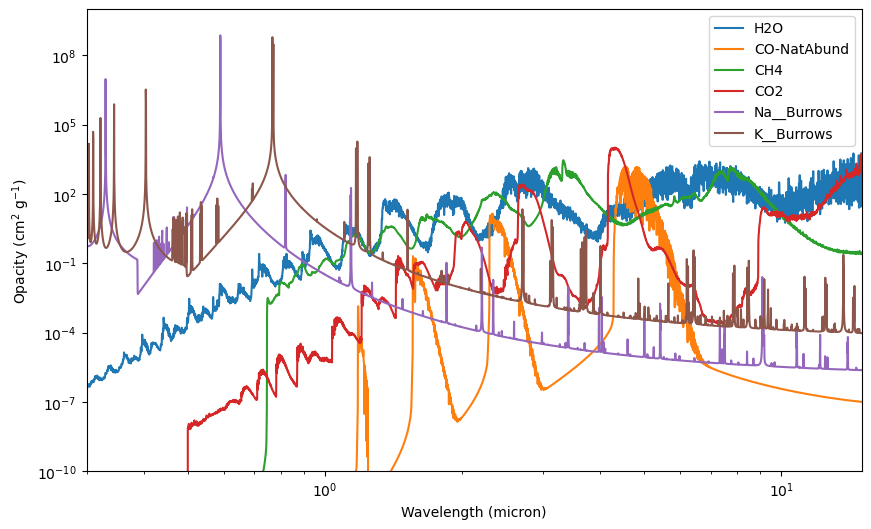

In [10]:
plot_radtrans_opacities(atmosphere,
                        atmosphere.line_species,
                        temperature=1500.,
                        pressure_bar=0.1)

plt.yscale('log')
plt.xscale('log')
plt.ylim([1e-10,1e10])
plt.xlim([0.3,15.])
plt.ylabel('Opacity (cm$^2$ g$^{-1}$)')
plt.xlabel('Wavelength (micron)')
plt.legend()

You can also use chemical equilibrium abundances for the relative weighting, here at C/O=0.55 (solar) and metallicity of 0 (solar).
Not that it will notify you if it does not find a given species from `atmosphere.line_species` in the chemical abundance dictionary exactly, for example it will use the `CO` abundance for `CO-NatAbund`, etc.

Loading chemical equilibrium chemistry table from file '/Users/molliere/Desktop/input_data_v3/input_data/pre_calculated_chemistry/equilibrium_chemistry/equilibrium_chemistry.chemtable.petitRADTRANS.h5'... Done.


/Users/molliere/Documents/Project_Docs/petitRADTRANS/petitRADTRANS/plotlib/plotlib.py:1037: UserWarning: Name of line absorber not found in chemical abundance table. Weighted CO-NatAbund with chemical mass fraction of species CO.
  warnings.warn('Name of line absorber not found in chemical abundance table.'
/Users/molliere/Documents/Project_Docs/petitRADTRANS/petitRADTRANS/plotlib/plotlib.py:1037: UserWarning: Name of line absorber not found in chemical abundance table. Weighted Na__Burrows with chemical mass fraction of species Na.
  warnings.warn('Name of line absorber not found in chemical abundance table.'
/Users/molliere/Documents/Project_Docs/petitRADTRANS/petitRADTRANS/plotlib/plotlib.py:1037: UserWarning: Name of line absorber not found in chemical abundance table. Weighted K__Burrows with chemical mass fraction of species K.
  warnings.warn('Name of line absorber not found in chemical abundance table.'


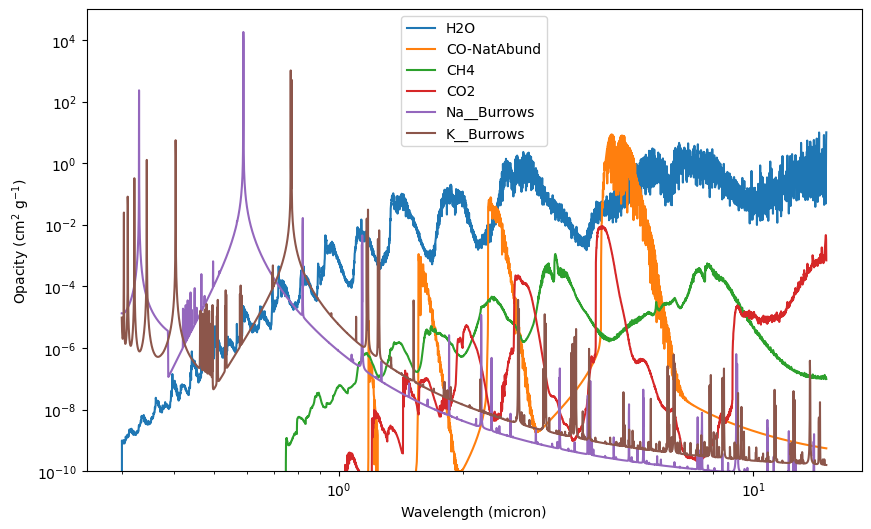

In [11]:
plot_radtrans_opacities(atmosphere,
                        atmosphere.line_species,
                        temperature=1500.,
                        pressure_bar=0.1,
                        co_ratio=0.55,
                        log10_metallicity=0.,
                        mass_fractions='eq')


plt.yscale('log')
plt.xscale('log')
plt.ylim([1e-10,1e5])
plt.ylabel('Opacity (cm$^2$ g$^{-1}$)')
plt.xlabel('Wavelength (micron)')
plt.legend()

Or you choose the mass fractions of the absorber yourself. Note that ``plot_opas`` also supports all keyword arguments of ``matplotlib.plot()`` (here we use ``linestyle`` as an example).

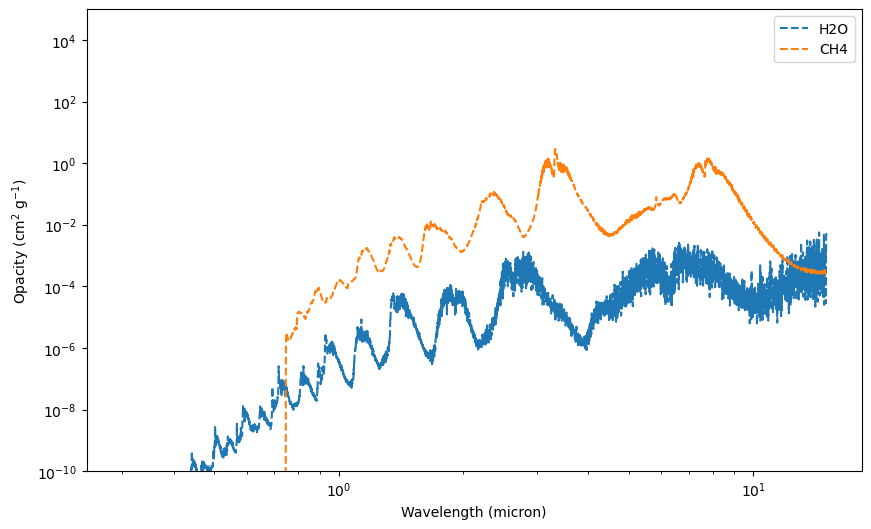

In [12]:
mass_fractions = {}
mass_fractions['H2O'] = 1e-6
mass_fractions['CH4'] = 1e-3

plot_radtrans_opacities(atmosphere,
                        ['H2O', 'CH4'],
                        temperature=1500.,
                        pressure_bar=0.1,
                        mass_fractions=mass_fractions,
                        linestyle = '--')

plt.yscale('log')
plt.xscale('log')
plt.ylim([1e-10,1e5])
plt.ylabel('Opacity (cm$^2$ g$^{-1}$)')
plt.xlabel('Wavelength (micron)')
plt.legend()

If you set `return_opacities=True` it will return a dictionary with wavelengths and opacities for the various line absorbers you request, instead of plotting them. Then you can make a plot yourself (or other things)...

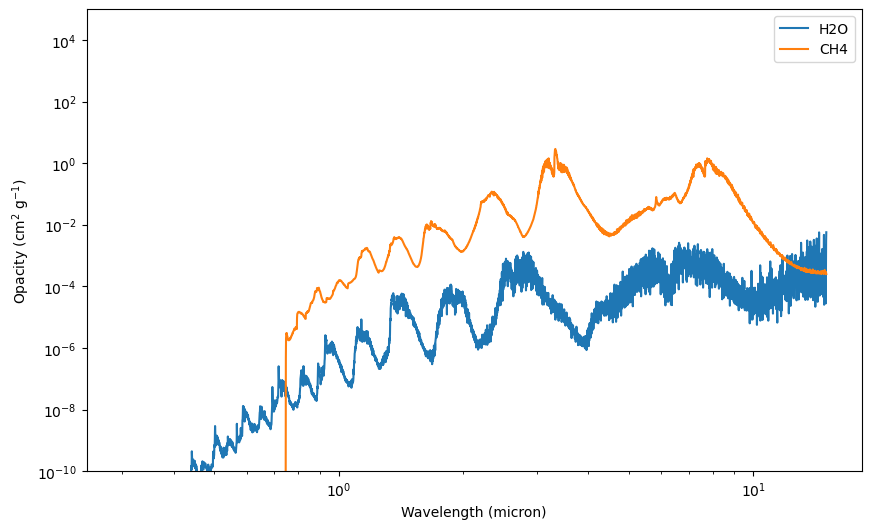

In [13]:
opacities = plot_radtrans_opacities(atmosphere,
                                      ['H2O', 'CH4'],
                                      temperature=1500.,
                                      pressure_bar=0.1,
                                      mass_fractions=mass_fractions,
                                      return_opacities=True)

for species in opacities.keys():
    plt.plot(opacities[species][0],
             opacities[species][1],
             label = species)
             
plt.yscale('log')
plt.xscale('log')
plt.ylim([1e-10,1e5])
plt.ylabel('Opacity (cm$^2$ g$^{-1}$)')
plt.xlabel('Wavelength (micron)')
plt.legend()